# Main notebook

For quick and generic simulations.

## Imports

In [ ]:
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

In [2]:
# %matplotlib widget

import lppydsmc as ld
import plotting

# other imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import os
from pathlib import Path
from pprint import pprint
# you can choose the seed here
np.random.seed(1111)

## System choice

Four default systems can be initialized using the following cell.

In [3]:
system_type = 'thruster_three_grids' # thruster, cylinder

# ---------------------- System --------------------
dz = 0.001
typical_lenght = 0.001 # typical size of the system (minimum distance between two walls for example)
                       # used for computing the mean free path later on (not used in the simulation)
                       # just useful to have an idea of it.

if system_type == 'tube':
    system, idx_out_walls, idx_in_wall = ld.systems.helper.system_rectangle(l_x = 0.01, l_y = 0.001)
    
elif system_type == 'square':
    system, idx_out_walls, idx_in_wall = ld.systems.helper.system_rectangle(l_x = 0.01, l_y = 0.01)

elif(system_type == 'cylinder'):
    system, idx_out_walls, idx_in_wall = ld.systems.helper.cylinder_system(res = 4, l_x = 0.003, l_y = 0.001, c_x = 0.0015 , c_y = 0.0005, r = 0.0001)

elif(system_type == 'thruster'):
    dp = 1e-3
    dict_thruster = {
        'w_in' : 5*dp,
        'l_in' : 3*dp,
        'w_1' : 3*dp,
        'l_1' : dp,
        'l_int' : dp,
        'w_2' : dp,
        'l_2' : 10*dp,
        'w_out' : 5*dp,
        'l_out' : dp,
        'offsets' : np.array([0,0]) 
    }

    system, idx_out_walls, idx_in_wall = ld.systems.helper.thruster_system(**dict_thruster)
    # idx_out_walls = [10, 9, 11] # not the input wall

elif(system_type == 'thruster_three_grids'):
    dp = 1e-3
    dict_thruster = {
        'w_in' : 5*dp,
        'l_in' : 3*dp,
        'w_1' : 3*dp,
        'l_1' : dp,
        'l_int' : dp,
        'w_2' : dp,
        'l_2' : 10*dp,
        'l_int_2' : dp,
        'w_3' : 3*dp,
        'l_3' : 1*dp,
        'w_out' : 5*dp,
        'l_out' : dp,
        'offsets' : np.array([0,0]) 
    }
    system, idx_out_walls, idx_in_wall = ld.systems.helper.thruster_three_grids_system(**dict_thruster)
    # idx_out_walls = [13, 14, 15] # not the input wall

offsets = system.get_offsets()
system_shape = system.system_shape()
a = system.get_dir_vects()
segments = system.get_segments()

## DSMC grid creation

In [4]:
# grid :
mean_numbers_per_cell = np.array([10000, 100]) # 20 # choose them so that each specie has the same weight
max_numbers_per_cell = 10*mean_numbers_per_cell
# factor 10 is completely overshot (Note : a future version will have dynamic arrays instead of static one)

if system_type == 'tube':
    resolutions = np.array((10,1), dtype = int) # tube

elif system_type == 'square':
    resolutions = np.array((3,3), dtype = int) # tube

elif system_type == 'thruster':
    resolutions = np.array((16,5), dtype = int)

elif(system_type == 'cylinder'):
    resolutions = np.array((9,9), dtype = int)

elif system_type == 'thruster_three_grids':
    resolutions = np.array((18,5), dtype = int)
    
cells_number = np.prod(resolutions)
grid = ld.data_structures.Grid(cells_number, np.sum(max_numbers_per_cell))

# --------- useful quantity for the simulation ------------ #
volume_cell = dz * system_shape[0]/resolutions[0] * system_shape[1]/resolutions[1]


## Particles

In [5]:

# useless
def init_max_proba(radii, mean_speeds, grid_shape):
    # radii and v_mean are of size Ns(number of species)
    # grid_shape is of size Nc (the number of cells)
    shape_pmax = [radii.shape[0], radii.shape[0]] + list(grid_shape)
    pmax = np.ones(tuple(shape_pmax), dtype = float)
    cross_sections = np.ones(tuple(shape_pmax), dtype = float)

    for i in range(pmax.shape[0]):
        for j in range(i+1):
            if(i==j):
                cross_sections[i,j] = np.pi * 4*radii[i]**2
                pmax[i,j] *= 2*mean_speeds[i] * np.pi * 4*radii[i]**2  # we'll take the max proba straight away ?
            else:
                cross_sections[i,j] = np.pi * (radii[i]+radii[1])**2 
                pmax[i,j] *= np.abs(mean_speeds[i]-mean_speeds[j]) * np.pi * (radii[i]+radii[1])**2   # we'll take the max proba straight away ?
    return pmax, cross_sections

def cross_sections(radii, mean_speeds):
    # radii and v_mean are of size Ns(number of species)
    # grid_shape is of size Nc (the number of cells)
    shape_out = [radii.shape[0], radii.shape[0]]
    cross_sections = np.ones(tuple(shape_out), dtype = float)

    for i in range(cross_sections.shape[0]):
        for j in range(i+1):
            if(i==j):
                cross_sections[i,j] = np.pi * 4*radii[i]**2
            else:
                cross_sections[i,j] = np.pi * (radii[i]+radii[1])**2 
                cross_sections[j,i] = cross_sections[i,j]
    return cross_sections

def convert(species):
    """
    Convert from dictionnary of species to dictionnary of quantities.
    """
    dico = {}
    
    types = []
    densities = []
    charges = []
    masses = []
    radii = []
    temperatures = []
    
    for key, val in species.items():
        types.append(key)
        densities.append(val['density'])
        charges.append(val['charge'])
        masses.append(val['mass'])
        radii.append(val['radius'])
        temperatures.append(val['temperature'])
        
        
    dico['types'] = types
    dico['densities'] = np.array(densities)
    dico['charges'] = np.array(charges)
    dico['masses'] = np.array(masses)
    dico['radii'] = np.array(radii)
    dico['temperatures'] = np.array(temperatures)
    
    # count of species
    dico['count'] = len(types)
    
    return dico

def species_setup(species, init_number_per_cells, number_of_cells, cell_volume):
    params = convert(species)
    
    types = params['types']
    densities = params['densities']
    charges = params['charges']
    masses = params['masses']
    radii = params['radii']
    temperatures = params['temperatures']
    
    # computed quantities
    size_arrays = init_number_per_cells*number_of_cells # max size for the array
    
    params['mean_speeds'] =  ld.utils.physics.maxwellian_mean_speed(temperatures, masses)
    params['containers'] = [ld.data_structures.Particle(types[k], charges[k], masses[k], radii[k], size_arrays[k]) for k in range(params['count'])]
    
    params['total_number_particles_simu'] = init_number_per_cells * number_of_cells
    params['total_number_particles_real'] = cell_volume * densities * number_of_cells 
    params['particles_weight'] = params['total_number_particles_real']/params['total_number_particles_simu']
    params['particles_weight'] = params['particles_weight'].astype(int)
    w0 = params['particles_weight'][0]
    for w in params['particles_weight']:
        assert(w0==w)
    params['particles_weight'] = w0
    params['densities_dsmc'] = densities/params['particles_weight']
    
    params['cross_sections'] = cross_sections(radii, params['mean_speeds']) # np.array([params['containers'][k].get_params()[3] for k in range(params['count'])])
    
    params['mean_free_paths'] = ld.utils.physics.mean_free_path(params['cross_sections'], np.sum(densities)) # taking the sum of all densities
    params['mean_free_times'] = ld.utils.physics.mean_free_time(params['mean_free_paths'], v_mean = params['mean_speeds'])
    
    return params

In [6]:
species = {
    'I' : {
        'density' : 3.2e19, # m-3
        'charge' : 0, # C
        'mass' : ld.utils.physics.get_mass_part(53, 53, 74), # kg
        'radius' : 2e-10, # m
        'temperature' : 300, # K
    },
    'I-' : {
        'density' : 3.2e17, # m-3
        'charge' : ld.utils.physics.ELECTRON_CHARGE, # C
        'mass' : ld.utils.physics.get_mass_part(53+1, 53, 74), # kg
        'radius' : 2e-10, # m
        'temperature' : 1000, # K
    }
}

reactions_list = [
    'I- : I'
]


In [7]:
params_species = species_setup(species, init_number_per_cells = mean_numbers_per_cell, number_of_cells = cells_number, cell_volume = volume_cell)
reactions = ld.advection.reactions.parse(reactions_list)
print(reactions)

{'I-': {'#': 1, 'reactants': ['I-'], 1: ['I']}}


## Initialization of particles

In [8]:
init_particles = False

# TODO:  make it compatible with several species
if(init_particles):
    # you have to decice your strategy to initialize a 2D array of size Nx5
    # where N is the number of particle
    # and each particle is given [x, y, vx, vy, vz].
    init_size = mean_number_per_cell*np.prod(resolutions)
    extremal_values = system.get_extremal_values() 
    loc = 0
    vel_std = ld.utils.physics.gaussian(temperature, mass)
    x = np.random.uniform(low = extremal_values['min_x'], high = extremal_values['max_x'], size = init_size)
    y = np.random.uniform(low = extremal_values['min_y'], high = extremal_values['max_y'], size = init_size)
    vx = np.random.normal(loc=0.0, scale=vel_std, size = init_size)
    vy = np.random.normal(loc=0.0, scale=vel_std, size = init_size)
    vz = np.random.normal(loc=0.0, scale=vel_std, size = init_size)
    new = np.stack((x,y,vx,vy,vz), axis = 1) 

    container.add_multiple(new)

## Load particles

In [9]:
load_particles = True

# TODO:  make it compatible with several species
if(load_particles):
    dir_path = Path('results/')
    name = 'neutral_three_grids.h5'
    store = pd.HDFStore(dir_path/name)
    df = store['df']
    unique_index = df.index.unique().values
    new = df.loc[df.index == unique_index[-1]][['x','y','vx','vy','vz']].values
    params_species['containers'][0].add_multiple(new)
    print(new.shape[0])
    store.close()
    
load_particles_2 = False

# TODO:  make it compatible with several species
if(load_particles_2):
    dir_path = Path('results/')
    name = 'test_dmsc_reactions_with_loading.h5'
    store = pd.HDFStore(dir_path/name)
    df = store['df']
    unique_index = df.index.unique().values
    new_I = df.loc[(df.index == unique_index[-1]) & (df['species']==0.0)][['x','y','vx','vy','vz']].values
    new_Im = df.loc[(df.index == unique_index[-1]) & (df['species']==1.0)][['x','y','vx','vy','vz']].values

    params_species['containers'][0].add_multiple(new_I)
    params_species['containers'][1].add_multiple(new_Im)
    store.close()
    print(new_I.shape[0])
    print(new_Im.shape[0])

266002


## Injection params 

In [10]:
inject_particles = True

drifts = np.array([0,2000.], dtype = float) # if you want to add drifts

if(inject_particles):
    densities_dsmc = params_species['densities_dsmc']
    mean_speeds = params_species['mean_speeds']
    temperatures = params_species['temperatures']
    masses = params_species['masses']
    in_wall = segments[idx_in_wall]
    in_vect = np.array([a[idx_in_wall,1], -a[idx_in_wall,0]]) # should be normalized
    in_vect = in_vect/np.linalg.norm(in_vect)
    
    # for the injection
    debits= ld.utils.physics.maxwellian_flux(densities_dsmc, mean_speeds)*np.linalg.norm(in_wall[:2]-in_wall[2:])*dz
    vel_stds = ld.utils.physics.gaussian(temperatures, masses)

# Saving directory and name

In [11]:
# which directory is used to save the data
# and under what name.
dir_path = Path('results/')
name = 'test_dmsc_reactions_with_loading_lots.h5'  # _with_loading_2

saver = ld.data.saver.Saver(dir_path, name)

In [12]:
# electric field and stuff
import lppydsmc.poisson_solver as ps

charge_density = {
            'value' : '0',  # must be a string too
            'degree' : 0,
            'kwargs' : {}
            }

potential_field, electric_field = ps.helper.thruster(dimensions = dict_thruster, mesh_resolution = 100, \
                                                     potential_electrode_1 = '30', potential_electrode_2 = '300', \
                                                     potential_electrode_3 = '-100', charge_density = charge_density)


## Simulation parameters

In [13]:
# Simulation params
iterations = 2000
dt = 1e-8 # in sec.

# saving params
saving_period = 50 # when do we save various data (see the simulation algo)
adding_period = 5 # when to we add to the dataframe that contains the particles position and velocity

# advection function - returns a 2D arrays containing the acceleration for each of the given particle
    # here arr is a N x 5 array. N particles, and for each one : x, y, vx, vy, vz is stored.
    # very simple for now - as there is no electric fields, nor any force in the system 
    # thus no acceleration

accelerations = np.zeros(shape = (params_species['containers'][0].get_max_size(), 3))

def f_i(arr, t):
    return np.concatenate((arr[:,2:4], accelerations[:arr.shape[0]]), axis = 1)

# args is given to euler_explicit and then given to *f* (the advection function) in addition to arr and dt.
# in our case, it is not needed. However, we could imagine a system with an electric field computed at the setup phase, 
# and we would like to give it as an args.
args_i = []
scheme_i = ld.utils.schemes.euler_explicit # rk4; euler_explicit


# advection function - returns a 2D arrays containing the acceleration for each of the given particle
    # here arr is a N x 5 array. N particles, and for each one : x, y, vx, vy, vz is stored.
    
def f_im(arr, t, m, q, electric_field):
    der = np.zeros((arr.shape[0], 5)) # (vx, vy, ax, ay, az)
    fact  = q/m
    for k, part in enumerate(arr):
        try:
            der[k,2:4] =  fact * electric_field(part[:2]) # no acceleration on z
        except Exception as e:
            pass
    der[:,:2] = arr[:,2:4]
    return der

# args is given to euler_explicit and then given to *f* (the advection function) in addition to arr and dt.
# in our case, it is not needed. However, we could imagine a system with an electric field computed at the setup phase, 
# and we would like to give it as an args.
args_im = [params_species['masses'][1], params_species['charges'][1], electric_field]
scheme_im = ld.utils.schemes.rk4

update_functions = [f_i, f_im]
args_update_functions = [args_i, args_im]
schemes = [scheme_i, scheme_im]

## Summing-up and plotting

In [14]:
n_tot_simu = np.sum(params_species['total_number_particles_simu'])

Initializing a system of type thruster_three_grids, of shape [0.018 0.005] with 90 cells.
Species parameters : 

{'charges': array([ 0.0e+00, -1.6e-19]),
 'containers': [<lppydsmc.data_structures.particle.Particle object at 0x7ff8d58bdb50>,
 'count': 2,
 'cross_sections': array([[5.02654825e-19, 5.02654825e-19],
       [5.02654825e-19, 5.02654825e-19]]),
 'densities': array([3.2e+19, 3.2e+17]),
 'densities_dsmc': array([1.e+13, 1.e+11]),
 'masses': array([2.12392283e-25, 2.12393194e-25]),
 'mean_free_paths': array([[0.0435255, 0.0435255],
       [0.0435255, 0.0435255]]),
 'mean_free_times': array([[0.00019532, 0.00010698],
       [0.00019532, 0.00010698]]),
 'mean_speeds': array([222.84430705, 406.85530673]),
 'particles_weight': 3200000,
 'radii': array([2.e-10, 2.e-10]),
 'temperatures': array([ 300, 1000]),
 'total_number_particles_real': array([2.88e+12, 2.88e+10]),
 'total_number_particles_simu': array([900000,   9000]),
 'types': ['I', 'I-']}
The simulation lasts 2000 iterations,

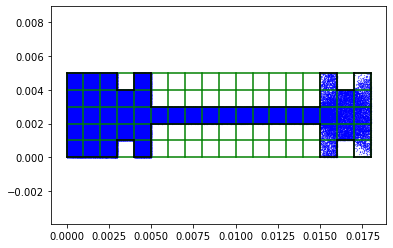

In [15]:
print(f'Initializing a system of type {system_type}, of shape {system_shape} with {np.prod(resolutions)} cells.')
print(f'Species parameters : \n')
pprint(params_species)
print(f'The simulation lasts {iterations} iterations, with a time step of {dt} s. Simulation duration : {dt*iterations} s')
# Note:  HDF5 uses a different format than csv, and the size on the disk is much different that what is expected. Check out : https://support.hdfgroup.org/HDF5/doc/H5.intro.html
# Here, you can at least multiply by 4 the size (considering we save much more than )
print(f'Disk space usage for saving this simulation (counting ONLY the particles positions and speed) and considering that we save {n_tot_simu} particles each time is {iterations//adding_period*n_tot_simu*(5*4)/1024**2} MB.') 
plotting.plt_tools.plot_system(params_species['containers'][0].get_array(), segments, 0.1, resolutions, system_shape, offsets);

# Simulation

The next cell takes care of the simulation. It algo gives you an idea of the evolution of the number of particles in the system and of its very general state.

At the end, the *saver* which saves the data is closed and you can then analyse your simulation using *analysis.ipynb*.

In [ ]:
df = pd.DataFrame(columns = ['x','y','vx','vy','vz','species']) # bucket for the particles - index of particles is the iteration number
df_out_particles = pd.DataFrame(columns = ['x','y','vx','vy','vz','species'])
nb_colls = np.zeros(grid.current.shape)
collisions_with_walls = 0
# df_collision_with_walls = pd.DataFrame(columns = ['x','y','type'])

# adding particle before the simulation - step 0
nb_species = params_species['count']
containers = params_species['containers']
types = params_species['types']
types_dict = {}
for idx, t in enumerate(types):
    types_dict[t] = idx
arrays = [containers[k].get_array() for k in range(nb_species)]
masses = [containers[k].mass() for k in range(nb_species)]

# No injection
# for arr, typ in zip(arrays, types):
#   df = df.append(pd.DataFrame(data=np.concatenate((arr, [typ]*arr.shape[0]), axis = 1), index=[0]*arr.shape[0], columns = ['x','y','vx','vy','vz','species']))

# defining useful arrays and ints 
    # injection
remains = np.zeros((nb_species)) # fractionnal part of the number of particles to inject (it is then passed to the following time step)
    # grids
averages = np.full(shape = grid.current.shape, fill_value = np.sum(mean_numbers_per_cell)) # average number of particles per cell
cross_sections = params_species['cross_sections']
pmax = 2*np.max(params_species['mean_speeds'])*np.mean(cross_sections)*np.ones(averages.shape) # max proba per cell in the simu
remains_per_cell = np.zeros(shape = grid.current.shape, dtype = float) # remains per cell for the particles collisions step

# SIMULATING
print('|{:^10}|{:^10}|{:^10}|{:^10}|{:^10}|{:^10}|{:^10}|'.format(' it ', ' INIT ', ' INJECT ', ' DEL ', ' TRY', ' C. WALLS', ' C. PARTS' ))
print('{:-^78}'.format(''))

t = 0.0
for it in range(1,iterations+1): # tqdm
    n1 = np.sum([containers[k].get_current() for k in range(nb_species)])
    
    # ------------------------- INJECTING PARTICLES -------------------------
    
    for k in range(nb_species):
        new, remains[k] = ld.injection.maxwellian(in_wall, in_vect, debits[k], vel_stds[k], dt, remains[k], drifts[k])
        containers[k].add_multiple(new)
        
    n2 = np.sum([containers[k].get_current() for k in range(nb_species)])
    
    # ---------------------------- PHASE : ADVECTING --------------------
        # MOVING PARTICLES
    arrays = [containers[k].get_array() for k in range(nb_species)]
    
    
    for k in range(nb_species):
        ld.advection.advect(arrays[k], update_functions[k], dt, t, args_update_functions[k], schemes[k]) # advect is inplace
    
        # HANDLING BOUNDARIES
    
    list_counts = []
    for k in range(nb_species):
        # initializing local variable
        arr = arrays[k]
        container = containers[k]
        
        count = np.full(fill_value = True, shape = arr.shape[0])
        idxes_out = []
        collided = []
        c = 0
        while(np.count_nonzero(count) > 0): # np.sum(count, where = count == True) > 0):
            c+=1
            ct, cp, cos_alpha = ld.advection.wall_collision.handler_wall_collision_point(arr[count], segments, a) # handler_wall_collision(arr[count], segments, a, radius)
            count, idxes_out_, cos_alpha = ld.advection.wall_collision.make_collisions_out_walls(arr, a, ct, cp, idx_out_walls, count, cos_alpha) # idxes_out : indexes of the particles (in arr) that got out of the system
            idxes_out.append(idxes_out_)

            # the first one that is received is the number of particles colliding with walls.
            if(c == 1):
                collisions_with_walls += np.count_nonzero(count) # np.sum(count, where = count == True)
                collided = np.copy(count) # np.where(collided[:collided_current], 1, 0)
                
        if(len(idxes_out)>0):
            idxes_out = np.sort(np.concatenate(idxes_out))
            
            collided_current = collided.shape[0]
            
            for idx in np.flip(idxes_out): # view = constant time 
                collided[idx] = collided[collided_current-1]
                collided_current -= 1
                
            list_counts.append(np.expand_dims(np.where(collided[:collided_current])[0], axis = 1))
            
            out_arr = container.pop_multiple(idxes_out)
            # using k instead of types[k] because this avoids using string in the dataframes which ALWAYS goes bad
            df_out_particles = df_out_particles.append(pd.DataFrame(data=np.concatenate((out_arr, np.expand_dims([k]*out_arr.shape[0], axis = 1)), axis = 1), index=[it]*out_arr.shape[0], columns = ['x','y','vx','vy','vz','species']))
        else:
            list_counts.append(np.array([])) # appending empty list to conserve the correspondance between rank in the global list and species
    

        
    particles_to_add = {}
    for k in range(nb_species):
        if types[k] in reactions:
            reacting_particles, particles_to_add_ = ld.advection.reactions.react(np.array(list_counts[k]), arrays = arrays, masses = masses, types_dict = types_dict, reactions = reactions[types[k]], p = None)
            # reacting_particles should be deleted in arrays[k]
            # particles_to_add should be added the the asssociated array
            list_counts[k] = reacting_particles # updating the actually reacting particles

            for key, val in particles_to_add_.items():
                if(key in particles_to_add):
                    particles_to_add[key] += val
                else:
                    particles_to_add[key] = val
        else:
            list_counts[k] = np.array([]) 
    # then and only then we delete everything in the update list_counts
    # print(f'Total collision with walls: {collisions_with_walls}')
    # print('DELETE')
    for k in range(nb_species): # here it's only one particle as it is colliding with the wall
        # thus it is easier to delete
        # print('{} - {}'.format(types[k], list_counts[k].shape[0]))
        containers[k].delete_multiple(list_counts[k])
        if(types[k] in particles_to_add):
            # print('ADDING - {} - {}'.format(types[k], len(particles_to_add[types[k]])))
            containers[k].add_multiple(np.array(particles_to_add[types[k]]))
    
    arrays = [containers[k].get_array() for k in range(nb_species)]
    
    grid.reset()
    for k in range(nb_species):
        arr = arrays[k]
        new_positions = ld.data_structures.grid.default_hashing(ld.data_structures.grid.pos_in_grid(arr[:,:2], resolutions, offsets, system_shape), res_y = resolutions[1])  
        parts_in_grid_format = ld.data_structures.grid.convert_to_grid_format(new = new_positions.shape[0], old = 0, container_idx = k)
        grid.add_multiple(new_positions, parts_in_grid_format)
 
    # ----------------------------- PHASE : DSMC COLLISIONS ----------------------------- 
        # TODO: make parallel (1st : note criticals functions in C++)    
    currents = grid.get_currents()
    averages = (it*averages+currents)/(it+1) # TODO: may be it too violent ? 

    remains_per_cell, nb_colls_, pmax, monitor = ld.collision.handler_particles_collisions(arrays, grid.get_grid(), currents, dt, averages, pmax, cross_sections, volume_cell, params_species['particles_weight'], remains_per_cell, monitoring = True)
    nb_colls += nb_colls_
    t += dt

    # ----------------------------- PLOTTING AND SAVING (OPTIONAL) ----------------------------- 
    if(it%adding_period == 0 or it == iterations):
        # print('Mean speed : ' + ' - '.join([str(np.mean(np.linalg.norm(arrays[k][:,2:], axis = 1))) for k in range(nb_species)]) + '\t m/s')
        for k, arr in enumerate(arrays):
            df = df.append(pd.DataFrame(data=np.concatenate((arr, np.expand_dims([k]*arr.shape[0], axis = 1)), axis = 1), index=[it]*arr.shape[0], columns = ['x','y','vx','vy','vz','species']))
            
    if(it%saving_period == 0 or it == iterations): # saving if last iteration too

        saver.save(it = it, append = {
                        'df' : df,
                        'collisions_per_cell' : nb_colls, # evolution of the number of collisions per cell - size : grid.shape[0] x grid.shape[1] (2D)
                        'total_distance' : float(monitor[0]), # evolution of the sum of the distance accross all cells 
                        'total_proba' : float(monitor[1]), # evolution of the sum of proba accross all cells
                        'pmax_per_cell' : pmax,  # evolution of the sum of pmax - per cell (2D)
                        'total_deleted' : len(idxes_out), # evolution of the number of deleted particles per cell (int)
                        'averages_per_cell' : averages, # evolution of the average number of particle per cell
                        'collisions_with_walls' : collisions_with_walls, # number of collisions with walls - evolution
                        'df_out_particles' : df_out_particles
                  })

        print('|{:^10}|{:^10}|{:^10}|{:^10}|{:^10}|{:^10}|{:^10}|'.format(it, n1, n2-n1, idxes_out.shape[0], c, collisions_with_walls, int(np.sum(nb_colls))))
        
        # resetting dataframe to not use too much memory
        collisions_with_walls = 0
        nb_colls = np.zeros(grid.current.shape)
        df = pd.DataFrame(columns = ['x','y','vx','vy','vz','species'])
        df_out_particles = pd.DataFrame(columns = ['x','y','vx','vy','vz','species'])
        
saver.close()

|    it    |   INIT   |  INJECT  |   DEL    |    TRY   | C. WALLS | C. PARTS |
------------------------------------------------------------------------------
